# Initialization

## Import libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F

# Load data

In [2]:
train = pd.read_csv('./data/train.csv')
test  = pd.read_csv('./data/test.csv')

## Dataloader

In [3]:
class CustomDataset(Dataset):
    def __init__(self, features: pd.DataFrame, labels: pd.Series = None):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.int64)\
            if labels is not None else None

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        if self.labels is None:
            return self.features[idx]
        return self.features[idx], self.labels[idx]

## Data processing

In [4]:
train_frac = 0.8
train_len = int(train_frac * len(train))
train_data, validation_data = train.iloc[:train_len], train.iloc[train_len:]

train_dataset = CustomDataset(train_data.drop(columns='label'), train_data['label'])
validation_dataset = CustomDataset(train_data.drop(columns='label'), train_data['label'])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=64, shuffle=True)

## Test the dataloader

Feature batch shape: torch.Size([64, 784])
Labels batch shape: torch.Size([64])


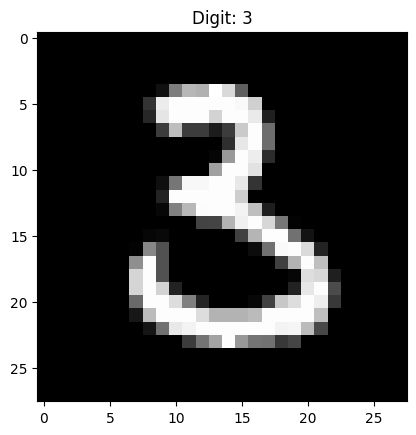

In [5]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

digit = (train_features[0]
    .detach().cpu().numpy()     # Convert to numpy because matplotlib isn't compatible with PyTorch Tensor
    .reshape(28, 28))           # Reshape from 1D to 2D so the image can be shown
label = train_labels[0]

plt.imshow(digit, cmap="gray")
plt.title(f"Digit: {label}")
plt.show()

# Modeling

## Building the model

In [6]:
class DenseModel(nn.Module):
    def __init__(self, in_features: int, num_classes: int):
        super().__init__()
        self.input = nn.Linear(in_features, 256)
        self.hidden = nn.Linear(256, 64)
        self.output = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden(x))
        logits = self.output(x)

        return logits

In [7]:
model = DenseModel(in_features=len(train.columns)-1, num_classes=train.label.nunique())
print(f"Model structure: {model}")

Model structure: DenseModel(
  (input): Linear(in_features=784, out_features=256, bias=True)
  (hidden): Linear(in_features=256, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)


## Training Loop

In [8]:
def training_loop(model, optimizer, epochs, loss_fn, data):
    for t in range(epochs):
        loop = tqdm(data, total=len(data))
        model.train()

        for _, (X, y) in enumerate(loop):
            optimizer.zero_grad()

            pred = model(X)
            loss = loss_fn(pred, y)
            
            loss.backward()
            optimizer.step()

            loop.set_description(f"Epoch [{t+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())

    print("Training completed.")

def validation_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
    test_loss /= num_batches
    correct /= size

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")


In [9]:
loss_fn = nn.CrossEntropyLoss()
lr = 1e-3
optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)
epochs = 10

training_loop(model, optimizer, epochs, loss_fn, train_dataloader)
validation_loop(validation_dataloader, model, loss_fn)

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

  0%|          | 0/525 [00:00<?, ?it/s]

Training completed.
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.044454



## Inference

In [10]:
def inference(dataloader, model):
    model.eval()
    predictions = []

    with torch.no_grad():
        for X in tqdm(dataloader, desc="Inference"):
            pred = model(X)
            predictions.append(pred.argmax(1).cpu().numpy())

    predictions = np.concatenate(predictions)
    
    return predictions

In [11]:
test_dataset = CustomDataset(test)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [12]:
predictions = inference(test_dataloader, model)

Inference:   0%|          | 0/438 [00:00<?, ?it/s]

In [13]:
torch.save(model.state_dict(), './model_dict/dense_model.pth')